In [94]:
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import *
from sklearn import metrics

# SK-learn Decomp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLP processors
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

# nltk.download(wordnet) this did not work so we have to use the below code.. lol

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
# Data splits

dat = pd.read_csv('data/nlp-getting-started/train.csv')
test_      = pd.read_csv('data/nlp-getting-started/test.csv')

div        = int(len(test_)/2)
test_data  = test_[div:]
dev_data   = test_[:div]

In [7]:
test_data.head()

,id,keyword,location,text
1631,5500,flames,"Fargo, ND",You were just waiting for us to go down in flames
1632,5504,flames,NaN,This is gonna go down in flames ?? https://t.c...
1633,5508,flames,"Here, There & Everywhere..",I'm listening to 'Zion' by Flames on #Pandora ...
1634,5511,flattened,NaN,I think that's been the best bit of this match...
1635,5512,flattened,support all girls!,why would anyone want to hear some type of shi...


In [8]:
num_disaster = len(dat[dat['target']==1])
num_nodisaster = len(dat[dat['target']==0])
num_disaster_kw =  len(dat[(dat.target == 1) & (~dat.keyword.isnull())])
num_nd_kw =  len(dat[(dat.target == 0) & (~dat.keyword.isnull())])
print('disaster tweets: ',num_disaster, '\nnot disaster tweets: ',num_nodisaster
      ,'\ndisaster tweets w/ kw: ', num_disaster_kw, '\nnot disaster tweets w/ kw: ', num_nd_kw)

disaster tweets:  3271 
not disaster tweets:  4342 
disaster tweets w/ kw:  3229 
not disaster tweets w/ kw:  4323


In [9]:
# helpers 
def sort(d,r):
    return sorted(d.items(),key=lambda item:item[1],reverse=r)

In [10]:
first_word = train_data.text.str.split(expand=True)[0]
first_words_c = dict(collections.Counter(first_word))
sorted_fw = sort(first_words_c,True)

x, y = zip(*sorted_fw[0:9]) # * to unpack tuple, zip to split 
plt.plot(x,y)
plt.title('Top 10 First Words in Data')
plt.xlabel('First Word/Token')
plt.ylabel('Counts')

NameError: name 'collections' is not defined

In [64]:
# remove the RT in tweets, as this is commonly used as 'retweet' by twitter users
dat[dat.text.str.contains('RT')]

,id,keyword,location,text,target
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
56,80,ablaze,South Africa,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1
75,109,accident,NaN,RT @SleepJunkies: Sleeping pills double your r...,0
86,128,accident,"New Hanover County, NC",FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999...,1
87,129,accident,Maldives,RT nAAYf: First accident in years. Turning ont...,1
...,...,...,...,...,...
7442,10650,wounds,Earth,RT @DianneG: Gunshot wound #9 is in the bicep....,0
7475,10692,wreck,"Lebanon, Tennessee",Watertown Gazette owner charged in wreck http:...,1
7510,10743,wreckage,WorldWide,#Australia #News ; RT janeenorman: 'High proba...,1
7518,10751,wreckage,Bangkok,CIA plot! *rolling eyes* RT @ajabrown: Chinese...,1


In [156]:
dat[dat.keyword.dropna(inplace='n').str.contains('body%20bags')]

ValueError: For argument "inplace" expected type bool, received type str.

In [65]:
# We would also remove # hashtags from the tweets texts, maybe even consider @
dat[dat.text.str.contains('#')]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
...,...,...,...,...,...
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1


In [62]:
# Should remove all feature sets that begin with HTTP, since they are links to other sites, causes noise
dat[dat.text.str.contains('http')]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
...,...,...,...,...,...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [47]:
# skip this shit for now

stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))



In [11]:
#read in data
# df = pd.read_csv(r'C:\Users\lwu31\OneDrive - JNJ\Documents\train.csv')
df = pd.read_csv('data/nlp-getting-started/train.csv')
# sample the data, acts as shuffling the data on row

#50/50 split between train and dev
# allocate more for traiing if we do it this way, i'll run some
# analysis to see if my cluster bootstrap can imrpove the models we run.
numtest = int(len(df)/3.5)
df_train = df[numtest:].reset_index(drop=True)
df_test = df[:int(numtest/2)].reset_index(drop=True)
df_dev = df[int(numtest/2):numtest].reset_index(drop=True)

train_data, train_label = df_train.text, df_train.target
dev_data, dev_label = df_dev.text, df_dev.target
test_data, test_label = df_test.text, df_test.target

#split into disaster and non disaster data
df_neg = df_train.loc[df_train.target == 0]
df_pos = df_train.loc[df_train.target == 1]

#split into disaster and nondisaster tweets only
neg_text = df_neg.text
pos_text = df_pos.text

print("Some data metrics\n")
print("Shape of train data:", df_train.shape)
print("\nMissing data in each column:\n" + str(df.isnull().sum()))
print("\nNumber of disaster tweets:\n"+ str(train_label.value_counts()))

Some data metrics

Shape of train data: (5438, 5)

Missing data in each column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Number of disaster tweets:
0    2996
1    2442
Name: target, dtype: int64


In [108]:
def preprocess(text, method=None, tokenizer=sent_tokenize, rm_stop=False):
    
    """Returns a text processed string.

    Arguments:
    text      -- Should only be a string, func is designed for loops
    method    -- Specify from s - stemmatize, l - lemmatize
    tokenizer -- Any tokenizer function, from word to sentence to tweet.
                 Tokenizer must not be an object.method unless you
                 specifiy it to be like TweetTokenizer.tokenize.
                 Sentence tokenizer is initialized here.
    """

    #remove line breaks
    text = re.sub(r"\n","",text)
    
    #convert to lowercase 
    text = text.lower()

    #remove digits and currencies 
    text = re.sub(r"\d+","",text) 
    text = re.sub(r'[\$\d+\d+\$]', "", text)      

    #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)

    #remove non-ascii
    text = re.sub(r'[^\x00-\x7f]',r' ',text) 

    #remove punctuation
    # Leave it? or talking point?!
    #text = re.sub(r'[^\w\s]','',text) 

    #remove hyperlinks
    #text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    
# remove trailing spaces
#     text = re.sub(r'[ \t]+$','', text)
#     filtered_tokens = [word for word in tokenizer(text) if not word in set(stopwords.words('english'))]
#     text = " ".join(filtered_tokens)

    if method == 'l':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in tokenizer(text)]
        return " ".join(lemm_tokens)
    
    elif method == 's':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in tokenizer(text)]
        return " ".join(stem_tokens)

    return text

In [109]:
# preprocess data-> split normally
# set random seed
# preprocess data-> split normally
# set random seed

np.random.seed(0)
#df_ = df.sample(frac=1).reset_index()

processed_full = []
for i in df_.text:
    processed_full.append(preprocess(i))
df_.text = processed_full

# numtest = int(len(df_)/3.5)
# df_test = df_[:int(numtest/2)].reset_index(drop=True)
# df_dev = df_[int(numtest/2):numtest].reset_index(drop=True)
numtest = int(len(df_)/5)
df_train = df_[numtest:].reset_index(drop=True)
df_test = df_[:numtest].reset_index(drop=True)

train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)
# Naive Bayes example run, using non clustered data first.
# I'll use TF-IDF in this to vectorize data.

tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
pred = m_nb.predict(dt_data)
pred_test = m_nb.predict(tt_data)
print('Test on no word root strip:')
print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))
print()

tokenizer = word_tokenize
np.random.seed(0)
df_ = df.sample(frac=1).reset_index()

stop_words = set(stopwords.words('english'))
processed_full = []
for i in df_.text:
    processed_full.append(preprocess(i,method='s',tokenizer=tokenizer))
df_.text = processed_full

# numtest = int(len(df_)/3.5)
# df_test = df_[:int(numtest/2)].reset_index(drop=True)
# df_dev = df_[int(numtest/2):numtest].reset_index(drop=True)
numtest = int(len(df_)/5)
df_train = df_[numtest:].reset_index(drop=True)
df_test = df_[:numtest].reset_index(drop=True)

train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)
# Naive Bayes example run, using non clustered data first.
# I'll use TF-IDF in this to vectorize data.

tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
pred = m_nb.predict(dt_data)
pred_test = m_nb.predict(tt_data)
print('Test on Stemmatize:')
print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))

# preprocess data-> split normally
# set random seed

# # stem
# studies -> studi
# study -> stud
# # lemm
# studies -> study
# study -> study

tokenizer = word_tokenize

np.random.seed(0)
df_ = df.sample(frac=1).reset_index()

stop_words = set(stopwords.words('english'))
processed_full = []
for i in df_.text:
    processed_full.append(preprocess(i,method='l',tokenizer=tokenizer))
df_.text = processed_full

# numtest = int(len(df_)/3.5)
# df_test = df_[:int(numtest/2)].reset_index(drop=True)
# df_dev = df_[int(numtest/2):numtest].reset_index(drop=True)
numtest = int(len(df_)/5)
df_train = df_[numtest:].reset_index(drop=True)
df_test = df_[:numtest].reset_index(drop=True)

train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)
# Naive Bayes example run, using non clustered data first.
# I'll use TF-IDF in this to vectorize data.

tfidf = CountVectorizer(ngram_range=(1,1))
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
pred = m_nb.predict(dt_data)
pred_test = m_nb.predict(tt_data)
print()
print('Test on Lemmatize:')
print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))

Test on no word root strip:
F1 Score: 0.7902
Accuracy: 0.7963

Test on Stemmatize:
F1 Score: 0.7894
Accuracy: 0.7950

Test on Lemmatize:
F1 Score: 0.8040
Accuracy: 0.8062


In [107]:
# This is removing stop words (countvectorize, lemma)
# F1 Score: 0.7922
# Accuracy: 0.7937

# this is including stop words (countvectorize, lemma)
# F1 Score: 0.8040
# Accuracy: 0.8062


In [85]:
def cluster_boot(df, n_clusters=2):
    # Must accept pre-processed data as DF
    
    """ Pre-Cluster data before splitting to enhance generalization"""
    dat = df.text
    tfidf = TfidfVectorizer()
    t_data = tfidf.fit_transform(dat)
    # pca = 
    cluster = KMeans(n_clusters=n_clusters).fit(t_data) # really bad clustering for loo
    df['assign'] = cluster.labels_
    
    if n_clusters == 2:
        if len(df[df['assign']==1]) > len(df[df['assign']==0]):
            s, l = 0, 1
        else:
            s, l = 1, 0
        len_valid = int(len(df[df['assign']==s])/2)
        df_test = df[df['assign']==s][:len_valid].reset_index(drop=True)
        df_dev = df[df['assign']==s][len_valid:].reset_index(drop=True)
        df_train = df[df['assign']==l].reset_index(drop=True)
    else:
        groups = [] # list of two tuples of clusters
        centroids = cluster.cluster_centers_
    
    # Simple prelim:: Sparse matrix for Spectral Clustering
    # if cluster is more than 2 then use the majority of clusters
    # closest to each other as training set and the rest as dev/test
    # notes: this method did not work, the spectral takes too long for
    # this size of a sparse matrix.
    #     elif typ == 'cv':
    #         cv = CountVectorizer()
    #         t_data = cv.fit_transform(dat)
    #         cluster = SpectralClustering(n_clusters=2).fit(t_data)
    return (df_train, df_dev, df_test)

df_train,df_dev,df_test = cluster_boot(df_)
train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)
tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
pred = m_nb.predict(dt_data)
pred_t = m_nb.predict(tt_data)
print('Metrics by cluster-splitting')
print('F1 Score: {:.4f}'.format(metrics.f1_score(dev_label, pred, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(dev_label, pred)))


Metrics by cluster-splitting
F1 Score: 0.7593
Accuracy: 0.7713


In [86]:
# TESTING 
dat = df_.text
tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(dat)
# not doing LSA, performing SVD is only for sake of cluster.. 
# due to very sparse data it is difficult to cluster on KMeans, 
# so we SVD I.E sparse->sparse to reduce dimensions
svd = TruncatedSVD()
t_data = svd.fit_transform(t_data)
cluster = KMeans(n_clusters=2).fit(t_data) # really bad clustering for loo

df['assign'] = cluster.labels_
if len(df[df['assign']==1]) > len(df[df['assign']==0]):
    s, l = 0, 1
else:
    s, l = 1, 0
len_valid = int(len(df[df['assign']==s])/2)
df_test = df[df['assign']==s][:len_valid].reset_index(drop=True)
df_dev = df[df['assign']==s][len_valid:].reset_index(drop=True)
df_train = df[df['assign']==l].reset_index(drop=True)

train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)
tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
pred = m_nb.predict(dt_data)
pred_t = m_nb.predict(tt_data)
print('Metrics by cluster-splitting')
print('F1 Score: {:.4f}'.format(metrics.f1_score(dev_label, pred, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(dev_label, pred)))


Metrics by cluster-splitting
F1 Score: 0.7775
Accuracy: 0.7829


In [82]:
dat = df.text
tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(dat)
# not doing LSA, performing SVD is only for sake of cluster.. 
# due to very sparse data it is difficult to cluster on KMeans, 
# so we SVD I.E sparse->sparse to reduce dimensions
svd = TruncatedSVD()
t_data = svd.fit_transform(t_data)
cluster = KMeans(n_clusters=6).fit(t_data) # really bad clustering for loo
cluster.cluster_centers_

array([[ 0.11675352, -0.07402458],
       [ 0.13734269,  0.1302569 ],
       [ 0.05008074, -0.02271451],
       [ 0.08913446,  0.06766382],
       [ 0.18523248, -0.13044627],
       [ 0.16083661,  0.02252606]])

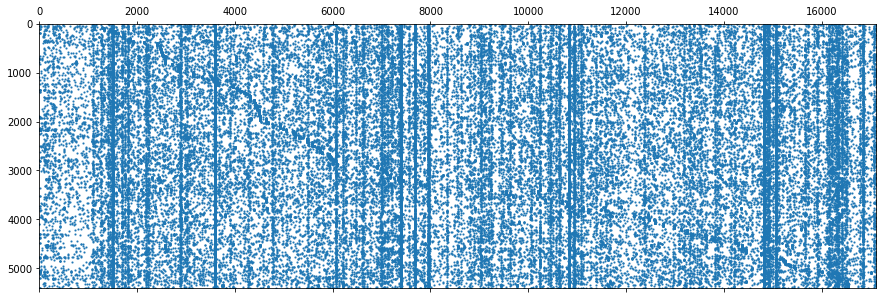

In [87]:
plt.figure(figsize=(15, 15))
plt.spy(t_data,markersize=1)

# reference
https://necromuralist.github.io/Neurotic-Networking/posts/nlp/01-twitter-preprocessing-with-nltk/